In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch_dct as dct

from lib.tools import *
from lib.jpeg import *
from lib.decomposition import *
from lib.regression import *
from lib.sketchml import *

# Image-like tensor

In [2]:
import cv2
import torchvision.transforms as transforms

In [3]:
image = cv2.imread("./dataset/jpeg/jpeg422jfif.jpg")
image = cv2.resize(image,(128,128),interpolation = cv2.INTER_AREA)
tensor = torch.from_numpy(image)
tensor_size = 128*128*3
# manipulate the tensor
value_mask = abs(tensor)>30
tensor = tensor* value_mask

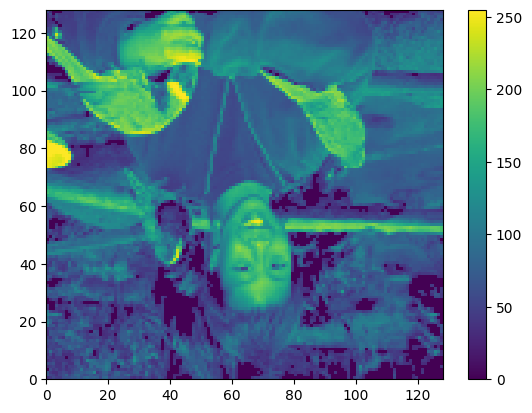

In [4]:
plt.figure()
plt.pcolormesh(tensor[:,:,1])
plt.colorbar()

## Get tensor charateristics

In [5]:
# actual_rank= calculate_cp_rank(tensor.numpy())
# print("The acutal rank of the tensor is: ", actual_rank)

In [6]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.13002522786458334


## Tensor compression

#### Jpeg

In [7]:
lowrank_jpeg_ratio = []
lowrank_jpeg_snr =[]
lowrank_jpeg_mse = []

In [8]:
for i in range(10):
    jpeg_quality = 55 + i *5
    encoded_data, compressed_size_jpeg = compressor_jpeg_direct(tensor, jpeg_quality)
    print("Compressed size: ", compressed_size_jpeg)

    reconstructed_tensor_jpeg = decompressor_jpeg_direct(tensor.shape, encoded_data )
    snr_jpeg = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_jpeg.numpy())
    mse_jpeg = calculate_mse(tensor.numpy(), reconstructed_tensor_jpeg.numpy())
    print("Reconstruction snr (dB): ", snr_jpeg)
    print("Reconstruction mse: ", mse_jpeg)
    
    lowrank_jpeg_ratio.append((tensor_size*4) / compressed_size_jpeg)
    lowrank_jpeg_snr.append(snr_jpeg)
    lowrank_jpeg_mse.append(mse_jpeg / torch.max(tensor).item())

Compressed size:  4500
Reconstruction snr (dB):  3.025283486810525
Reconstruction mse:  47.939188639322914
Compressed size:  4805
Reconstruction snr (dB):  3.184482457348883
Reconstruction mse:  46.213704427083336
Compressed size:  5163
Reconstruction snr (dB):  3.3748430173962363
Reconstruction mse:  44.2318115234375
Compressed size:  5666
Reconstruction snr (dB):  3.561670788649271
Reconstruction mse:  42.369364420572914
Compressed size:  6233
Reconstruction snr (dB):  3.8443795810106685
Reconstruction mse:  39.699137369791664
Compressed size:  7155
Reconstruction snr (dB):  4.253673932765767
Reconstruction mse:  36.128641764322914
Compressed size:  8529
Reconstruction snr (dB):  4.837697368150375
Reconstruction mse:  31.58270263671875
Compressed size:  11042
Reconstruction snr (dB):  6.089053795611878
Reconstruction mse:  23.676289876302082
Compressed size:  16363
Reconstruction snr (dB):  9.236613415280566
Reconstruction mse:  11.4698486328125
Compressed size:  35265
Reconstruction

#### Tensor decomposition

In [9]:
lowrank_decomposition_ratio =[]
lowrank_decomposition_snr = []
lowrank_decomposition_mse = []

In [10]:
for i in range(20):
    decom_rank_ratio = 0.05*(i+1) +0.5
    factors, compressed_size_decomposition = compressor_decomposition_slice_quality(tensor/255,decom_rank_ratio)
    print("Compressed size: ", compressed_size_decomposition)
    reconstructed_tensor_decomposition = decompressor_decomposition_slice(tensor.shape, factors)*255
    snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition.numpy())
    mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition.numpy())
    print("Reconstruction snr (dB): ", snr_decomposition)
    print("Reconstruction mse: ", mse_decomposition)

    lowrank_decomposition_ratio.append((tensor_size*4) / compressed_size_decomposition)
    lowrank_decomposition_snr.append(snr_decomposition)
    lowrank_decomposition_mse.append(mse_decomposition / torch.max(tensor).item())

Compressed size:  134144
Reconstruction snr (dB):  3.107657239672907
Reconstruction mse:  47.038483
Compressed size:  134144
Reconstruction snr (dB):  3.107657239672907
Reconstruction mse:  47.038483
Compressed size:  134144
Reconstruction snr (dB):  3.107657239672907
Reconstruction mse:  47.038483
Compressed size:  134144
Reconstruction snr (dB):  3.107657239672907
Reconstruction mse:  47.038483
Compressed size:  134144
Reconstruction snr (dB):  3.107657239672907
Reconstruction mse:  47.038483
Compressed size:  134144
Reconstruction snr (dB):  3.107657239672907
Reconstruction mse:  47.038483
Compressed size:  201216
Reconstruction snr (dB):  113.05017410115254
Reconstruction mse:  4.766522e-10
Compressed size:  201216
Reconstruction snr (dB):  113.05017410115254
Reconstruction mse:  4.766522e-10
Compressed size:  201216
Reconstruction snr (dB):  113.05017410115254
Reconstruction mse:  4.766522e-10
Compressed size:  201216
Reconstruction snr (dB):  113.05017410115254
Reconstruction mse

#### Regression

In [11]:
lowrank_regression_ratio = []
lowrank_regression_snr = []
lowrank_regression_mse = []

In [12]:
for i in range(10):
    regression_rank = i+1
    factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor.to(torch.float32), regression_rank)
    print("Compressed size: ", compressed_size_regression)

    reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
    snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
    mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
    print("Reconstruction snr (dB): ", snr_regression)
    print("Reconstruction mse: ", mse_regression)

    lowrank_regression_ratio.append((tensor_size*4) / compressed_size_regression)
    lowrank_regression_snr.append(snr_regression)
    lowrank_regression_mse.append(mse_regression / torch.max(tensor).item())

Compressed size:  12800.0
Reconstruction snr (dB):  -11.394409042871336
Reconstruction mse:  1326.3555
Compressed size:  13312.0
Reconstruction snr (dB):  -10.7730290691717
Reconstruction mse:  1149.5343
Compressed size:  13824.0
Reconstruction snr (dB):  -10.242850910416363
Reconstruction mse:  1017.429
Compressed size:  14336.0
Reconstruction snr (dB):  -9.847221225562615
Reconstruction mse:  928.8405
Compressed size:  14848.0
Reconstruction snr (dB):  -9.54706534945021
Reconstruction mse:  866.8133
Compressed size:  15360.0
Reconstruction snr (dB):  -8.890987841852748
Reconstruction mse:  745.27716
Compressed size:  15872.0
Reconstruction snr (dB):  -8.693533215064999
Reconstruction mse:  712.1514
Compressed size:  16384.0
Reconstruction snr (dB):  -8.289757146056061
Reconstruction mse:  648.92535
Compressed size:  16896.0
Reconstruction snr (dB):  -8.066824923876085
Reconstruction mse:  616.4552
Compressed size:  17408.0
Reconstruction snr (dB):  -7.874397073176568
Reconstruction m

#### Sketch ML

In [17]:
lowrank_sketchml_ratio = []
lowrank_sketchml_snr = []
lowrank_sketchml_mse = []

In [18]:
for i in range (10):
    d = (i+1) * 0.1
    a = round(2+0.2*i)
    minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,d,a)
    print("Compressed size: ", compressed_size_sketchml)

    reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
    snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    print("Reconstruction snr (dB): ", snr_sketchml)
    print("Reconstruction mse: ", mse_sketchml)
    
    lowrank_sketchml_ratio.append((tensor_size*4) / compressed_size_sketchml)
    lowrank_sketchml_snr.append(snr_sketchml)
    lowrank_sketchml_mse.append( mse_sketchml / torch.max(tensor).item())

/home/rex/gitRepo/split_DNN_framework/characteristics/lib/sketchml.py:185: RuntimeWarning: Mean of empty slice.
  bucket_means[k] = values[bucket_mask].mean()
/home/rex/archiconda3/envs/pytorch/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Compressed size:  9664
Reconstruction snr (dB):  -15.73912386914169
Reconstruction mse:  3606.8777
Compressed size:  18132
Reconstruction snr (dB):  nan
Reconstruction mse:  nan
Compressed size:  26684
Reconstruction snr (dB):  nan
Reconstruction mse:  nan
Compressed size:  52857
Reconstruction snr (dB):  nan
Reconstruction mse:  nan
Compressed size:  65811
Reconstruction snr (dB):  -9.675852020125488
Reconstruction mse:  892.9029
Compressed size:  78642
Reconstruction snr (dB):  -8.521958193756396
Reconstruction mse:  684.56525
Compressed size:  91470
Reconstruction snr (dB):  -7.420331599240195
Reconstruction mse:  531.1928
Compressed size:  104298
Reconstruction snr (dB):  -6.503880751554355
Reconstruction mse:  430.1373
Compressed size:  156167
Reconstruction snr (dB):  -2.7994250412082824
Reconstruction mse:  183.2996
Compressed size:  173272
Reconstruction snr (dB):  -1.8026962243397973
Reconstruction mse:  145.70976


# Plot

Text(0, 0.5, 'Reconstruction SNR [dB]')

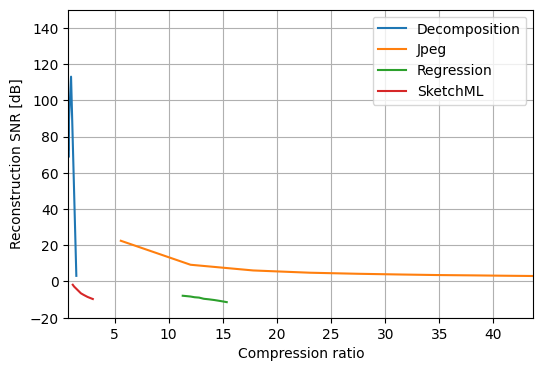

In [19]:
plt.figure(figsize=(6,4))
plt.plot(lowrank_decomposition_ratio, lowrank_decomposition_snr,label ="Decomposition")
plt.plot(lowrank_jpeg_ratio, lowrank_jpeg_snr,label ="Jpeg")
plt.plot(lowrank_regression_ratio, lowrank_regression_snr,label ="Regression")
plt.plot(lowrank_sketchml_ratio, lowrank_sketchml_snr,label ="SketchML")
plt.legend()
plt.grid()
plt.ylim([-20,150])
plt.autoscale(axis='x',tight=True)
plt.xlabel("Compression ratio")
plt.ylabel("Reconstruction SNR [dB]")

# Plotting